In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# state: [[x], [dx]]
# dynamics: [[dx], [ddx]]

start_state = np.vstack([0,0])
final_state = np.vstack([1,0])

N = 5
N_state = 2
N_control = 1

start_time = 0
end_time = 1
h = (end_time-start_time)/N

def variables_to_control_state(variables):
    control = np.array(variables[:N])
    positions = np.array(variables[N::2])
    velocities = np.array(variables[N+1::2])
    return positions, velocities, control

def objective_function(variables):
    positions, velocities, control = variables_to_control_state(variables)
    result = 0
    for k in range(N-1):
        result += 1/2*h*(control[k]**2+control[k+1]**2)
    return result

def eq_constraints(variables):
    positions, velocities, control = variables_to_control_state(variables)
    constraints = []

    # start constraint
    constraints.append(positions[0]-0)
    constraints.append(positions[N-1]-1)
    constraints.append(velocities[0]-0)
    constraints.append(velocities[N-1]-0)

    for k in range(N-1):
        constraints.append(positions[k+1]-positions[k]-h/2*(velocities[k+1]+velocities[k]))
        constraints.append(velocities[k+1]-velocities[k]-h/2*(control[k+1]+control[k]))
        
    return constraints

def initial_variables():
    us = np.zeros(N)
    x0s = np.linspace(0, 1, N)
    v0s = np.linspace(0, 0, N)
    xv0s = np.hstack(list(zip(x0s, v0s)))
    return np.hstack([us, xv0s])

In [3]:
initial_state = initial_variables()
constraints_dict = {"type": "eq", "fun": eq_constraints}

sol = minimize(
    fun = objective_function,
    x0 = initial_state,
    method="SLSQP",
    constraints=constraints_dict
)
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 29.411764581279304
       x: [ 8.824e+00  5.882e+00 ...  1.000e+00  0.000e+00]
     nit: 4
     jac: [ 1.765e+00  2.353e+00 ...  0.000e+00  0.000e+00]
    nfev: 64
    njev: 4

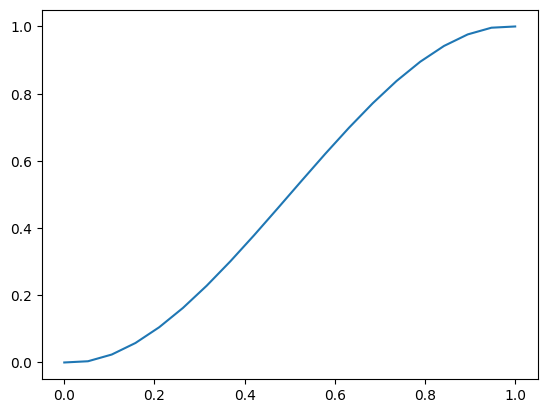

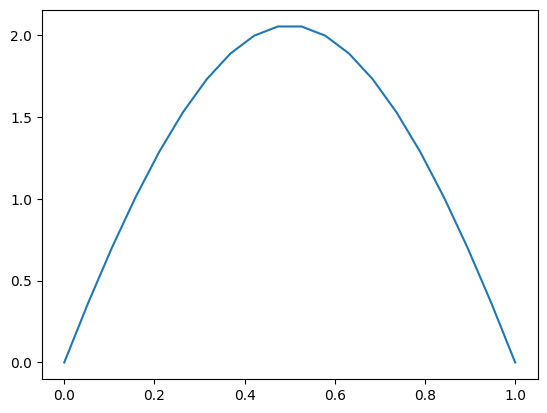

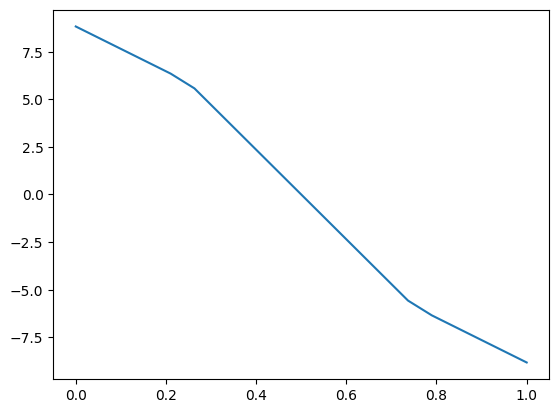

In [4]:
time = np.linspace(start_time, end_time, N)
positions, velocities, control = variables_to_control_state(sol.x)
N_new = 20
time_new = np.linspace(start_time, end_time, N_new)

position_spline = CubicSpline(time, positions)(time_new)
velocity_spline = CubicSpline(time, velocities)(time_new)
control_spline = np.interp(time_new, time, control)

plt.plot(time_new, position_spline)
plt.show()
plt.plot(time_new, velocity_spline)
plt.show()
plt.plot(time_new, control_spline)
plt.show()


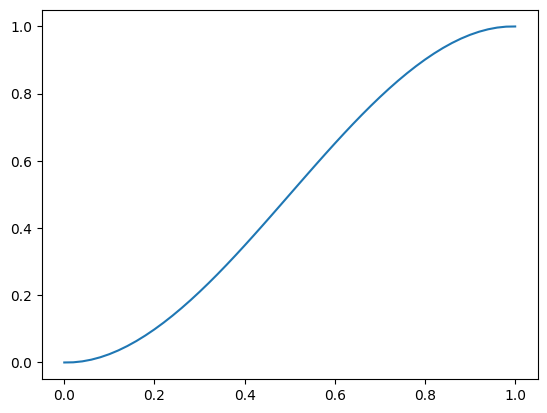

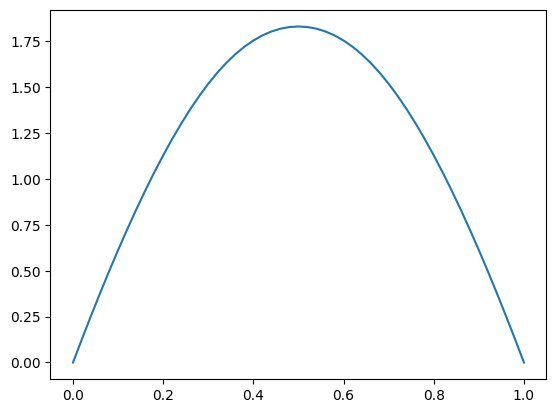

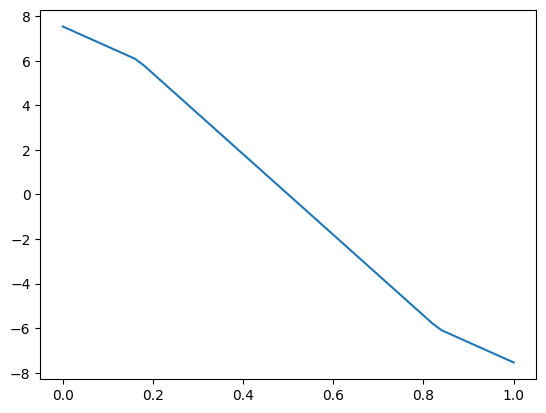

In [6]:
from lib.direct_collocation import DirectCollocation

def dynamics(state, control):
    state = state.T[0]
    v = state[1]
    u = control[0][0]
    return np.vstack([v, u])

N = 7
direct_collocation = DirectCollocation(N, dynamics, 2, 1)
N_spline = 51
state, control = direct_collocation.make_controller(1, N_spline, np.vstack([0,0]), np.vstack([1,0]))

time = np.linspace(0, 1, N_spline)
plt.plot(time, state[0])
plt.show()
plt.plot(time, state[1])
plt.show()
plt.plot(time, control[0])
plt.show()